# Logistic Regression

## Summary

- Binary classification
- Softmax regression

## Binary classification

### Problem formulation

Logistic regression is a classification algorithm used to estimate the probability that a data sample belongs to a particular class.

A logistic regression model computes a weighted sum of the input features (plus a bias term), then applies the *logistic* function to this sum in order to output a probability.

$$y' = \mathcal{h}_\theta(\pmb{x}) = \sigma(\pmb{\theta}^T\pmb{x})$$

The function output is thresholded to form the model's prediction:

- $0$ if $y' \lt 0.5$
- $1$ if $y' \geqslant 0.5$

### The logistic function (sigmoid)

Outputs a number between 0 and 1.

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

### Environment setup

In [51]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

Python version: 3.7.5


In [4]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

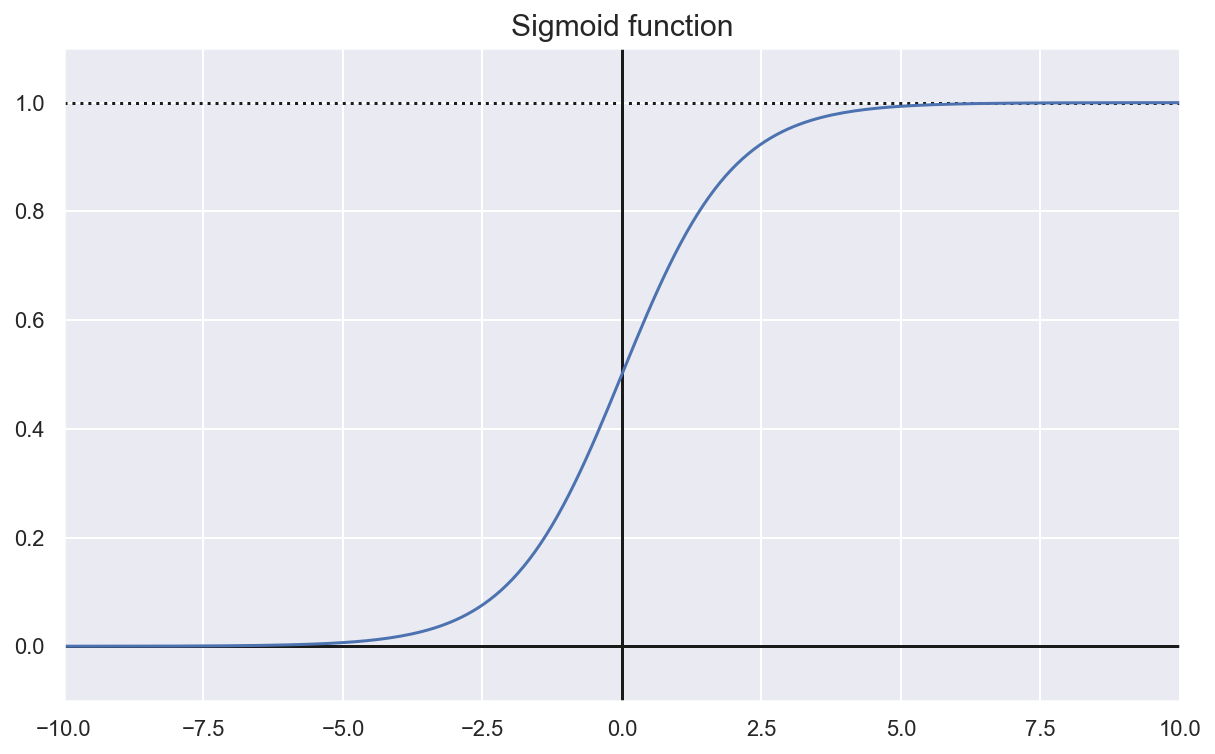

In [24]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Plot sigmoid function
plt.figure(figsize=(10, 6))
z = np.linspace(-10, 10, 200)
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(z, sigmoid(z), "b-")
plt.axis([-10, 10, -0.1, 1.1])
plt.title("Sigmoid function", fontsize=15)
plt.show()

### Loss function: Binary Crossentropy (log loss)

- $y^{(i)}$: expected result (either 0 or 1) for the $i$th data sample.
- $y'^{(i)}$: model output (probability) for the $i$th data sample.

$$\mathcal{L}(\boldsymbol{\pmb{\theta}}) = -\frac{1}{m}\sum_{i=1}^m \left(y^{(i)} \log_e(y'^{(i)}) + (1-y^{(i)}) \log_e(1-y'^{(i)})\right)$$

### Model training

- No analytical solution here because of the non-linear $\sigma()$ function: gradient descent is the only option.
- Since the loss function is convex, GD (with the right hyperparameters) is guaranteed to find the global loss minimum.

$$\nabla_{\theta}\mathcal{L}(\pmb{\theta}) = \begin{pmatrix}
       \ \frac{\partial}{\partial \theta_0} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \frac{\partial}{\partial \theta_1} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_n} \mathcal{L}(\boldsymbol{\theta})
     \end{pmatrix} = \frac{2}{m}\pmb{X}^T\left(\sigma(\pmb{X}\pmb{\theta}) - \pmb{y}\right)$$

### Example: using Logistic Regression to classify planar data

In [120]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")
assert sklearn.__version__ >= "0.20"

from sklearn.datasets import make_classification, make_blobs
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report

scikit-learn version: 0.22.1


In [227]:
def plot_data(x, y, figure=None):
    """Plot some 2D data"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()

    plt.plot(x[y == 0, 0], x[y == 0, 1], "or", alpha=0.5, label=0)
    plt.plot(x[y == 1, 0], x[y == 1, 1], "ob", alpha=0.5, label=1)
    plt.plot(x[y == 2, 0], x[y == 2, 1], "og", alpha=0.5, label=2)
    plt.xlim((min(x[:, 0]) - 0.1, max(x[:, 0]) + 0.1))
    plt.ylim((min(x[:, 1]) - 0.1, max(x[:, 1]) + 0.1))
    plt.legend()


def plot_decision_boundary(pred_func, x, y, figure=None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright)

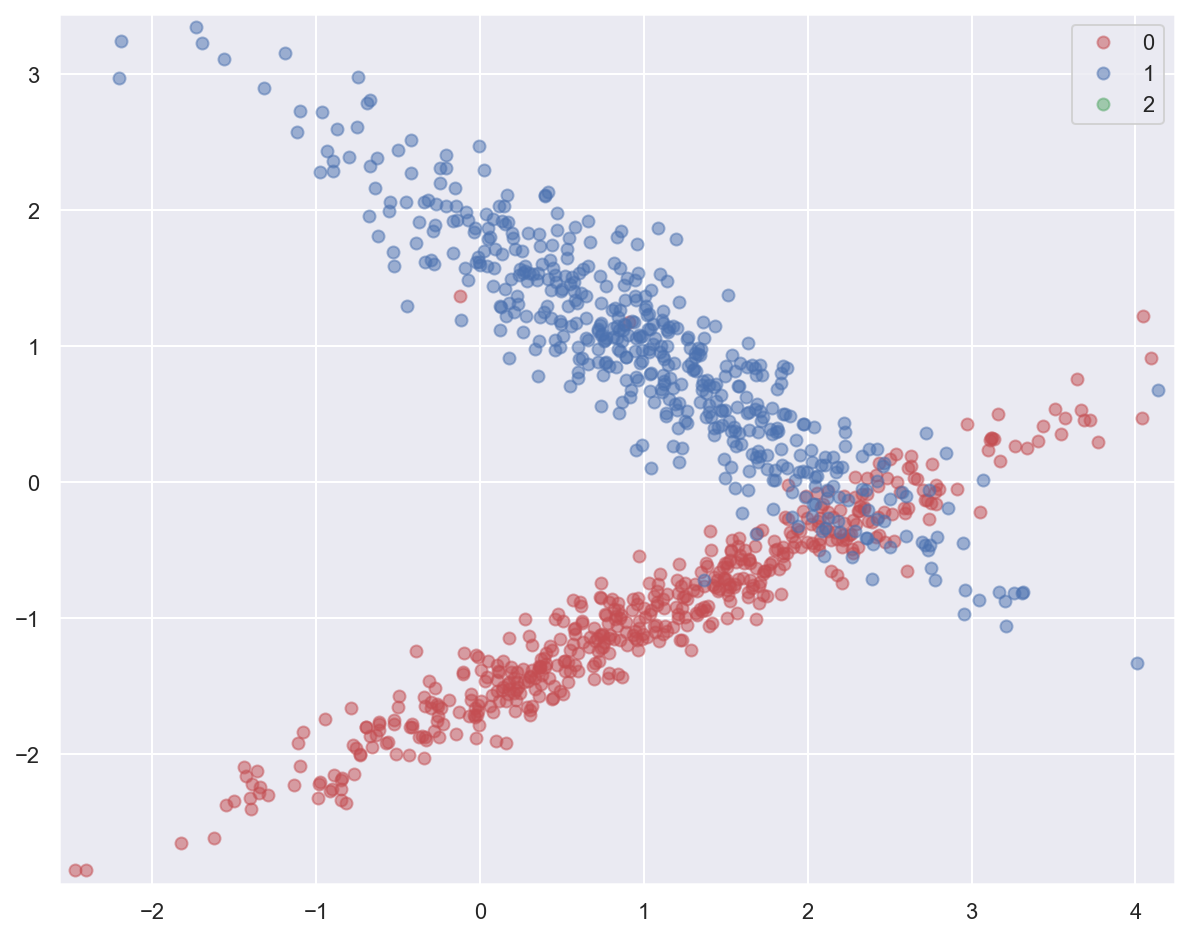

In [228]:
# Generate 2 classes of linearly separable data
x_train, y_train = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=42,
    n_clusters_per_class=1,
)
plot_data(x_train, y_train)

In [229]:
# Create a Logistic Regression model based on stochastic gradient descent
lr_model = SGDClassifier(loss="log")

# Train the model
lr_model.fit(x_train, y_train)

print(f"Model weights: {lr_model.coef_}, bias: {lr_model.intercept_}")

Model weights: [[-0.59107981  4.23316612]], bias: [1.3105687]


In [230]:
# Print report with classification metrics
print(classification_report(y_train, lr_model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       501
           1       0.92      0.88      0.90       499

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



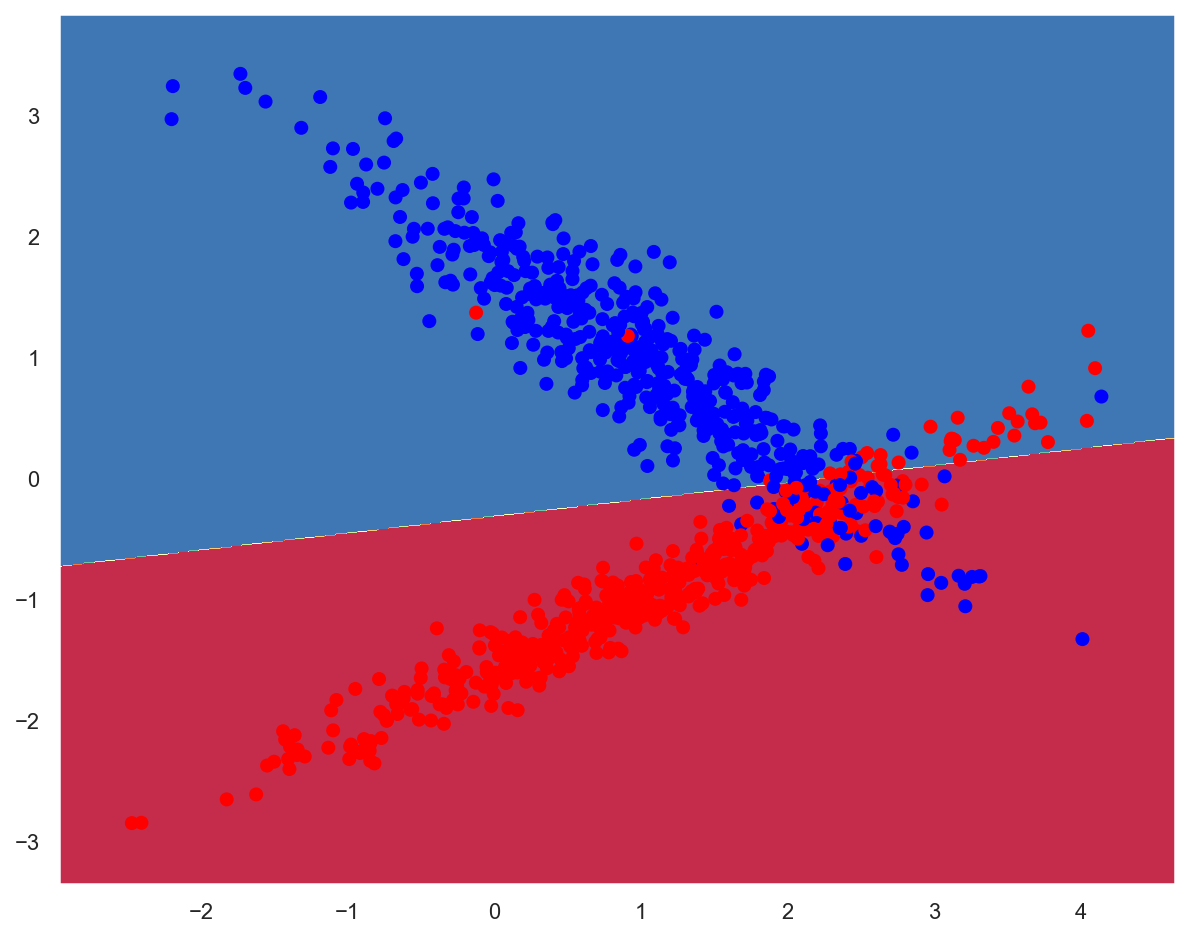

In [231]:
plot_decision_boundary(lambda x: lr_model.predict(x), x_train, y_train)

### Interactive example

[![LR on the TF playground](images/lr_tf_playground.png)](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=25&networkShape=1&seed=0.93645&showTestData=false&discretize=false&percTrainData=80&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&batchSize_hide=true&regularizationRate_hide=true&percTrainData_hide=true&numHiddenLayers_hide=true&problem_hide=true)

## Softmax regression

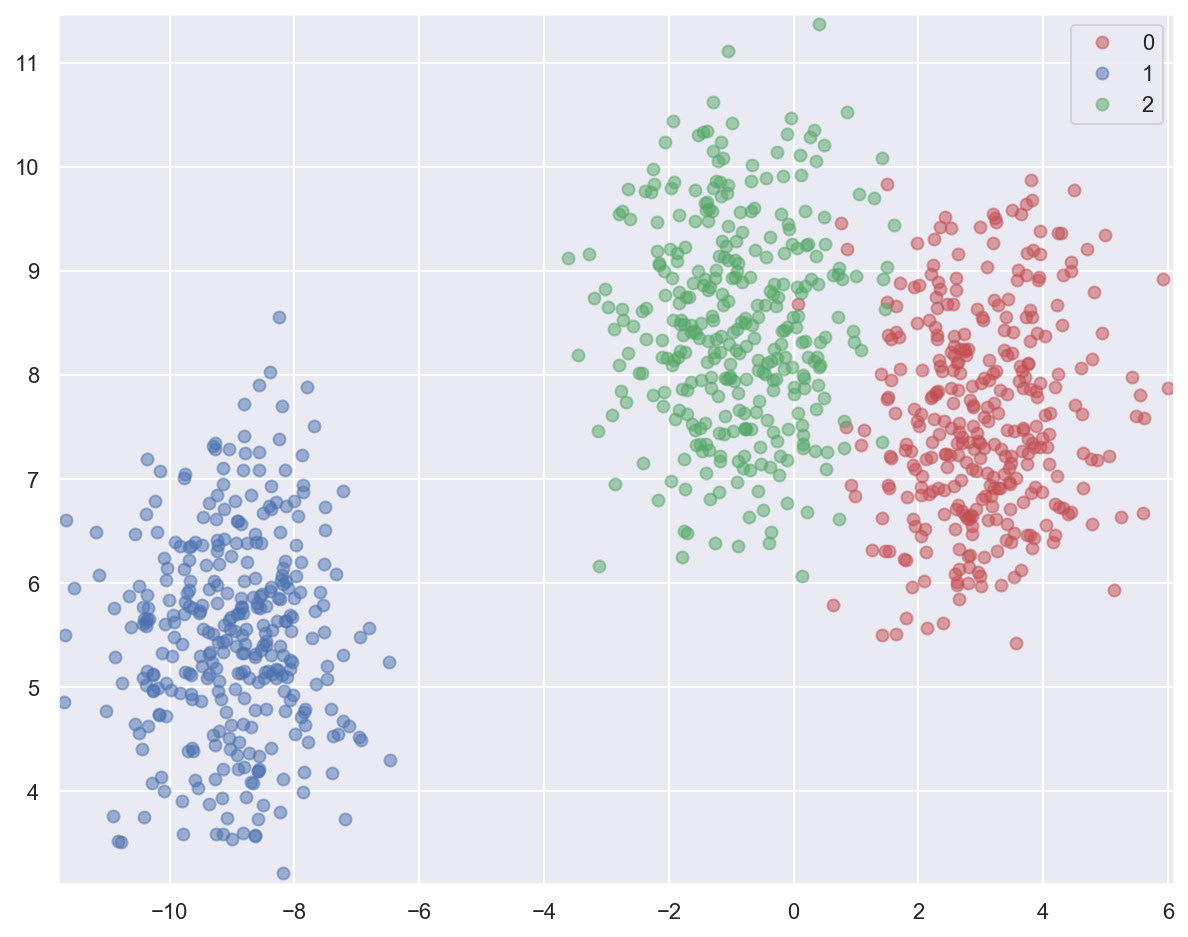

In [232]:
# Generate 3 classes of linearly separable data
x_train_multi, y_train_multi = make_blobs(n_samples=1000, n_features=2, centers=3)

plot_data(x_train_multi, y_train_multi)

In [233]:
# Create a Logistic Regression model based on stochastic gradient descent
lr_model_multi = SGDClassifier(loss="log")

# Train the model
lr_model_multi.fit(x_train_multi, y_train_multi)

print(f"Model weights: {lr_model_multi.coef_}, bias: {lr_model_multi.intercept_}")

Model weights: [[ 42.72085253  -9.94742348]
 [-13.16828011  -8.33667354]
 [ -1.43869304  42.53345076]], bias: [  22.19716017   -4.95083922 -331.60109539]


In [234]:
# Print report with classification metrics
print(classification_report(y_train_multi, lr_model_multi.predict(x_train_multi)))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       334
           1       0.97      1.00      0.98       333
           2       0.91      0.95      0.93       333

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



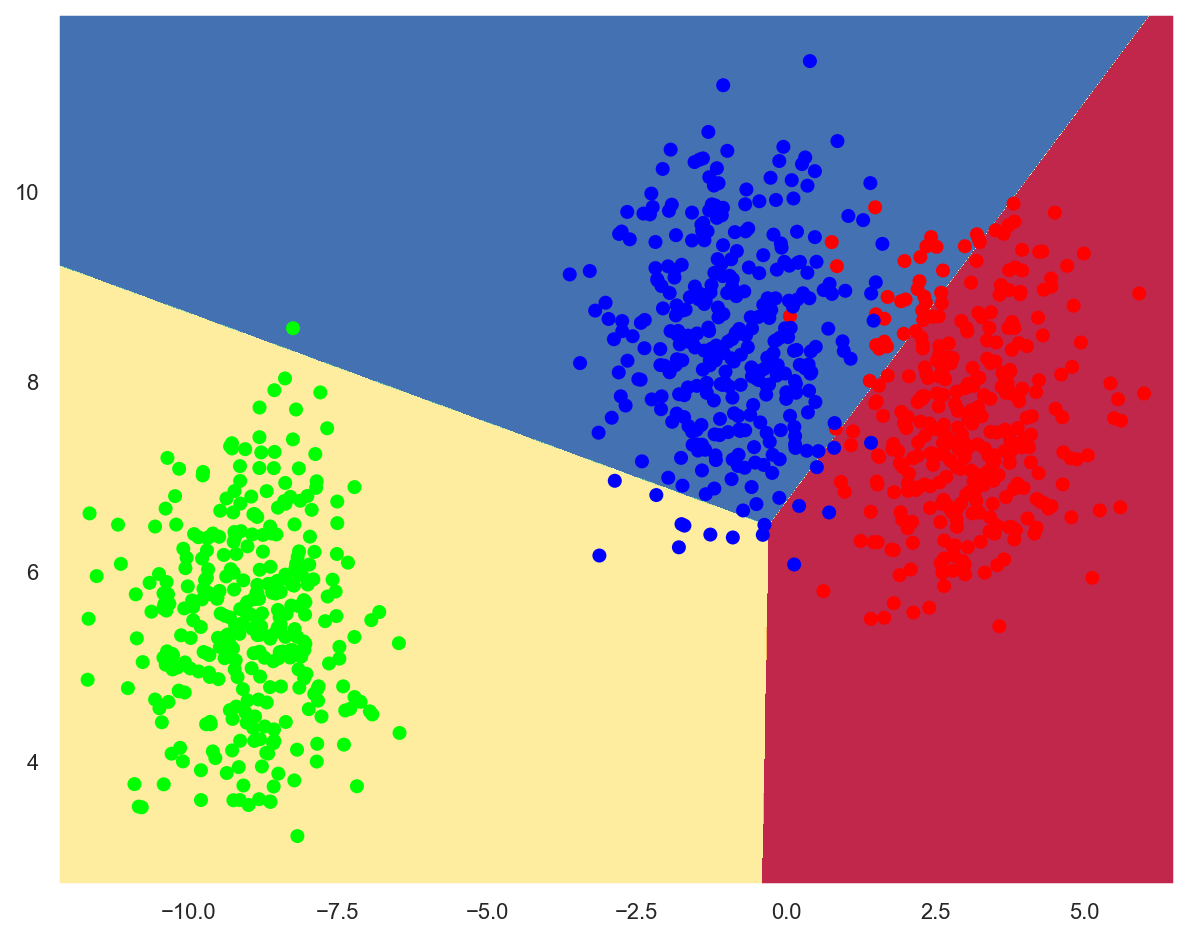

In [235]:
plot_decision_boundary(lambda x: lr_model_multi.predict(x), x_train_multi, y_train_multi)